#### Importing Libraries

In [1]:
# Core Libraries
import numpy as np
import pandas as pd

# Plotly Packages
import plotly.io as pio
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot

# Matplotlib and Seaborn
import matplotlib.pyplot as plt
import seaborn as sns
from string import ascii_letters

# Statistical Libraries
from scipy.stats import norm, skew, pearsonr, stats

# Regression Modeling
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Other Libraries
import warnings
warnings.filterwarnings("ignore")

## Data Collection
#### Medical Costs Dataset

In [2]:
df = pd.read_csv('insurance.csv')
# Copy of original data
df_1 = df.copy()
# Prevent numeric operations on this column
df['children'] =df['children'].astype('object')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


#### Dataset Variable Descriptions
Age: Age of the primary beneficiary.

Sex: Gender of the insurance contractor (female or male).

BMI: Body Mass Index, a measure that assesses body weight relative to height. It is calculated using the formula weight (kg) / height (m²) and ideally falls within the range of 18.5 to 24.9, indicating a healthy weight.

Children: Number of children or dependents covered by the health insurance policy.

Smoker: Indicates whether the beneficiary is a smoker.

Region: The geographical area of the beneficiary's residence in the U.S., categorized as Northeast, Southeast, Southwest, or Northwest.

Charges: The total medical costs incurred by the individual, as billed by the health insurance provider.

## Data Exploration

#### 1. Age Distribution

In [3]:
# Define the age categories
df['age_cat'] = np.nan
lst = [df]

# Categorize the ages
for col in lst:
    col.loc[(col['age'] >= 18) & (col['age'] <= 35), 'age_cat'] = 'Young Adult'
    col.loc[(col['age'] > 35) & (col['age'] <= 55), 'age_cat'] = 'Middle Aged Adult'
    col.loc[col['age'] > 55, 'age_cat'] = 'Senior'

# Prepare data for the pie chart
labels = df["age_cat"].unique().tolist()
amount = df["age_cat"].value_counts().tolist()

# Define the colors for the chart
colors = ["#2E6F8E", "#BDDF26", "#482173"]

# Create the pie chart
trace = go.Pie(labels=labels, values=amount,
               hoverinfo='label+percent', textinfo='value',
               textfont=dict(size=20),
               marker=dict(colors=colors, 
                           line=dict(color='#000000', width=1.5)))

# Define layout
layout = go.Layout(title="Distribution by Age Category")

# Combine data and layout into the figure
fig = go.Figure(data=[trace], layout=layout)

# Display the chart
fig.show()


#### 2. Charge Distribution

In [4]:
charge_dist = df["charges"].values

fig = make_subplots(
rows=1, cols=1,
)

fig.add_trace(
go.Histogram(
x=charge_dist,
histnorm='probability',
name="Charges Distribution",
marker=dict(color='#29AF7F')
),
row=1, col=1
)

fig.update_layout(
title="Charge Distribution",
xaxis_title="Charges",
yaxis_title="Probability",
bargap=0.05
)

iplot(fig)

#### 3. Age, Charges, BMI

In [5]:
# Create the scatter plot
fig = go.Figure()

# Add scatter trace
fig.add_trace(
    go.Scatter(
        x=df['age'], 
        y=df['charges'], 
        mode='markers', 
        marker=dict(
            size=10, 
            color=df['bmi'],
            colorscale='Viridis',
            showscale=True,  # Show color scale
            colorbar=dict(title='BMI'),  # Colorbar title
        ),
        hovertemplate='<b>Age:</b> %{x}<br><b>Charges:</b> $%{y}<br><b>BMI:</b> %{marker.color}<extra></extra>'
    )
)

# Update layout
fig.update_layout(
    title='Relationship Between Age, Charges, and BMI',
    xaxis=dict(title='Age'),
    yaxis=dict(title='Charges'),
    template='plotly_white', 
    height=600,
    width=1000
)

# Display the figure
fig.show()

In [6]:
# Calculate the correlation matrix
correlation_matrix = df[['age', 'charges', 'bmi']].corr()

# Create the heatmap
fig = go.Figure(
    data=go.Heatmap(
        z=correlation_matrix.values,  # Correlation values
        x=correlation_matrix.columns,  # Labels for x-axis
        y=correlation_matrix.index,  # Labels for y-axis
        colorscale='Viridis',  # Use Viridis colormap
        colorbar=dict(title='Correlation'),  # Colorbar title
        zmin=-1,  # Min correlation value
        zmax=1,   # Max correlation value
        hovertemplate='<b>%{x}</b> vs <b>%{y}</b>: %{z:.2f}<extra></extra>'
    )
)

# Update layout
fig.update_layout(
    title='Correlation Heatmap: Age, Charges, and BMI',
    xaxis=dict(title='Features', tickangle=-45),  # Rotate x-axis labels
    yaxis=dict(title='Features'),
    template='plotly_white',  # Clean background
    height=600,
    width=800,
)

# Display the figure
fig.show()

#### 4. Charges by Age Categories

In [7]:
# Calculate Mean and Median for the updated age categories
# Means
avg_ya_charge = df["charges"].loc[df["age_cat"] == "Young Adult"].mean()
avg_ma_charge = df["charges"].loc[df["age_cat"] == "Middle Aged Adult"].mean()
avg_s_charge = df["charges"].loc[df["age_cat"] == "Senior"].mean()

# Medians
med_ya_charge = df["charges"].loc[df["age_cat"] == "Young Adult"].median()
med_ma_charge = df["charges"].loc[df["age_cat"] == "Middle Aged Adult"].median()
med_s_charge = df["charges"].loc[df["age_cat"] == "Senior"].median()

# Bar plot for Mean
average_plot = go.Bar(
    x=['Young Adults', 'Middle Aged Adults', 'Senior'],
    y=[avg_ya_charge, avg_ma_charge, avg_s_charge],
    name='Mean',
    marker=dict(color="#29AF7F")
)

# Bar plot for Median
med_plot = go.Bar(
    x=['Young Adults', 'Middle Aged Adults', 'Senior'],
    y=[med_ya_charge, med_ma_charge, med_s_charge],
    name='Median',
    marker=dict(color="#541352")
)

# Create subplots
fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=('Average Charges by Age', 'Median Charges by Age'),
    shared_yaxes=True
)

# Add traces
fig.add_trace(average_plot, row=1, col=1)
fig.add_trace(med_plot, row=1, col=2)

# Update layout
fig.update_layout(
    title='Charges by Age Categories',
    xaxis_title='Age Category',
    yaxis_title='Patient Charges ($)',
    bargap=0.15,  # Bar gap
    showlegend=True,
    template='plotly_white',  # Clean background style
    height=500,
    width=900
)

# Show plot
fig.show()

#### 4. Charges by Smoking Status

In [8]:
# Filter data for smokers and non-smokers
smoker_charges = df[df['smoker'] == 'yes']['charges']
nonsmoker_charges = df[df['smoker'] == 'no']['charges']

# Create histograms
smoker_hist = go.Histogram(
    x=smoker_charges,
    name='Smoker',  # Legend name
    marker=dict(color='#B8DE29'),
    opacity=0.6,  # Transparency to overlap histograms
)

nonsmoker_hist = go.Histogram(
    x=nonsmoker_charges,
    name='Non-Smoker',  # Legend name
    marker=dict(color='#287D8E'),
    opacity=0.6,
)

# Create the layout
layout = go.Layout(
    title='Distribution of Charges by Smoking Status',
    xaxis=dict(
        title='Medical Charges ($)',
        titlefont=dict(size=14),
    ),
    yaxis=dict(
        title='Frequency',
        titlefont=dict(size=14),
    ),
    barmode='overlay',  # Overlay histograms
    template='plotly_white',  # Clean background
    legend=dict(
        title='Smoking Status',
        font=dict(size=12),
    ),
    height=500,  # Plot height
    width=900,  # Plot width
)

# Combine traces and layout
fig = go.Figure(data=[smoker_hist, nonsmoker_hist], layout=layout)

# Show plot
fig.show()

#### 5. Median Charges by Region

In [9]:
# Average charge by Region
df["region"].unique()

# Median Charges per Region
southwest = np.median(df["charges"].loc[df["region"] == "southwest"].values)
southeast = np.median(df["charges"].loc[df["region"] == "southeast"].values)
northwest = np.median(df["charges"].loc[df["region"] == "northwest"].values)
northeast = np.median(df["charges"].loc[df["region"] == "northeast"].values)

lst = [southwest, southeast, northwest, northeast]

data = [go.Scatterpolar(
  r = [southwest, southeast, northwest, northeast],
  theta = ['SouthWest', 'SouthEast', 'NorthWest', 'NorthEast'],
  fill = 'toself'
)]

layout = go.Layout(
    title="Median Charges by Region",
  
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, max(lst)]
    )
  ),
  showlegend = False
)


fig = go.Figure(data=data, layout=layout)
iplot(fig, filename = "radar/basic")

## Data Cleaning

In [10]:
print(df)

# Clean null values (drop rows with any NaN) and remove duplicates
df_cleaned = df.dropna().drop_duplicates()

# Print the cleaned dataframe
print(df_cleaned)

      age     sex     bmi children smoker     region      charges  \
0      19  female  27.900        0    yes  southwest  16884.92400   
1      18    male  33.770        1     no  southeast   1725.55230   
2      28    male  33.000        3     no  southeast   4449.46200   
3      33    male  22.705        0     no  northwest  21984.47061   
4      32    male  28.880        0     no  northwest   3866.85520   
...   ...     ...     ...      ...    ...        ...          ...   
1333   50    male  30.970        3     no  northwest  10600.54830   
1334   18  female  31.920        0     no  northeast   2205.98080   
1335   18  female  36.850        0     no  southeast   1629.83350   
1336   21  female  25.800        0     no  southwest   2007.94500   
1337   61  female  29.070        0    yes  northwest  29141.36030   

                age_cat  
0           Young Adult  
1           Young Adult  
2           Young Adult  
3           Young Adult  
4           Young Adult  
...            

## Data Splitting

In [11]:
# In this section we will preprocess our data
# First we should split our original data.

from sklearn.model_selection import train_test_split

# Shuffle our dataset before splitting

df_cleaned = df_cleaned.sample(frac=1, random_state=1)

X = df_cleaned.drop("charges", axis=1)
y = df_cleaned["charges"]

# Split into both training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Categorical Encoding

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import check_array
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64, handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        X = check_array(X, dtype=np.object, accept_sparse='csc')
        n_samples, n_features = X.shape
        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]
        
        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        raise ValueError(f"Found unknown categories {diff} in column {i}")
                le.classes_ = np.array(np.sort(self.categories[i]))
        self.categories_ = [le.classes_ for le in self._label_encoders_]
        return self

    def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=np.object)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)
        
        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])
            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    raise ValueError(f"Found unknown categories {diff} in column {i}")
                else:
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype)
        
        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)
        
        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples), n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]), dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        return out

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

numerics = X_train.select_dtypes(exclude="object")
categoricals = X_train.select_dtypes(include="object")

# Column transformer to handle numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerics.columns.tolist()),
        ('cat', OneHotEncoder(sparse_output=False), categoricals.columns.tolist())  # Use sparse_output=False
    ])

# Fit and transform the data
scaled_xtrain = preprocessor.fit_transform(X_train)

## Modeling

In [15]:
train = X_train.join(y_train, lsuffix='_X_train', rsuffix='_y_train')
test = X_test.join(y_test, lsuffix='_X_test', rsuffix='_y_test')

# Random seed
np.random.seed(42)

# Shuffle Randomly the training set
train = train.sample(frac=1)
train.head()

,age,sex,bmi,children,smoker,region,age_cat,charges
317,54,male,32.775,0,no,northeast,Middle Aged Adult,10435.06525
661,57,female,23.980,1,no,southeast,Senior,22192.43711
1320,31,male,31.065,3,no,northwest,Young Adult,5425.02335
385,19,male,34.400,0,no,southwest,Young Adult,1261.85900
493,61,male,43.400,0,no,southwest,Senior,12574.04900


In [16]:
X_train = sm.add_constant(scaled_xtrain)
y_train = y_train.values

model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     219.7
Date:                Sat, 04 Jan 2025   Prob (F-statistic):          1.50e-300
Time:                        21:13:54   Log-Likelihood:                -10845.
No. Observations:                1069   AIC:                         2.172e+04
Df Residuals:                    1054   BIC:                         2.180e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7739.5644    181.122     42.731      0.0

In [17]:
print('Parameters: ', results.params)
print('R2: ', results.rsquared)

Parameters:  [ 7.73956439e+03  3.69034080e+03  2.08695433e+03  4.07507068e+03
  3.66449371e+03  2.22497984e+00  4.58547605e+02  1.56949242e+03
  9.86612023e+02  2.35850694e+03  2.36418043e+03 -8.13748504e+03
  1.58770494e+04  2.66050012e+03  2.21436088e+03  1.40080555e+03
  1.46389785e+03  2.14728832e+03  2.88616758e+03  2.70610849e+03]
R2:  0.7447702582887035


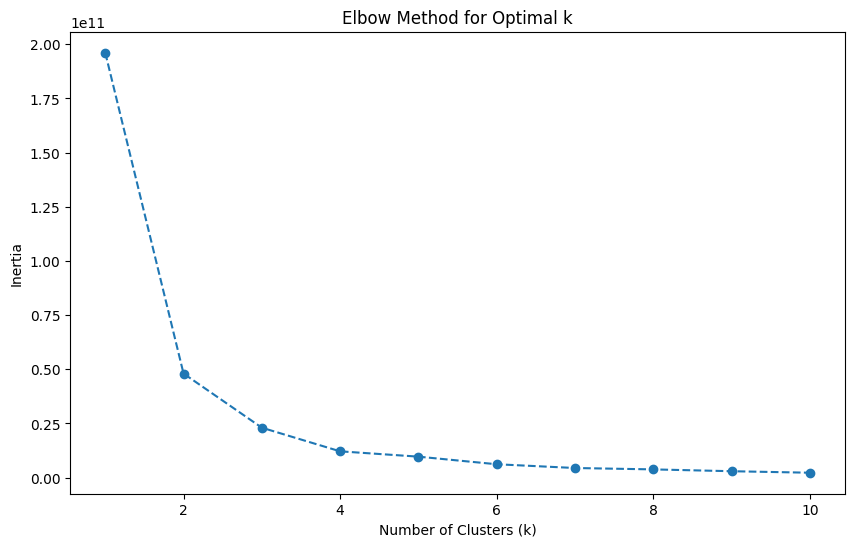

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Replace this with your actual DataFrame
X = df[["bmi", "charges"]]

# Compute inertia for different values of k
inertia = []
k_range = range(1, 11)  # Test k from 1 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)  
kmeans.fit(X)

KMeans(n_clusters=3)

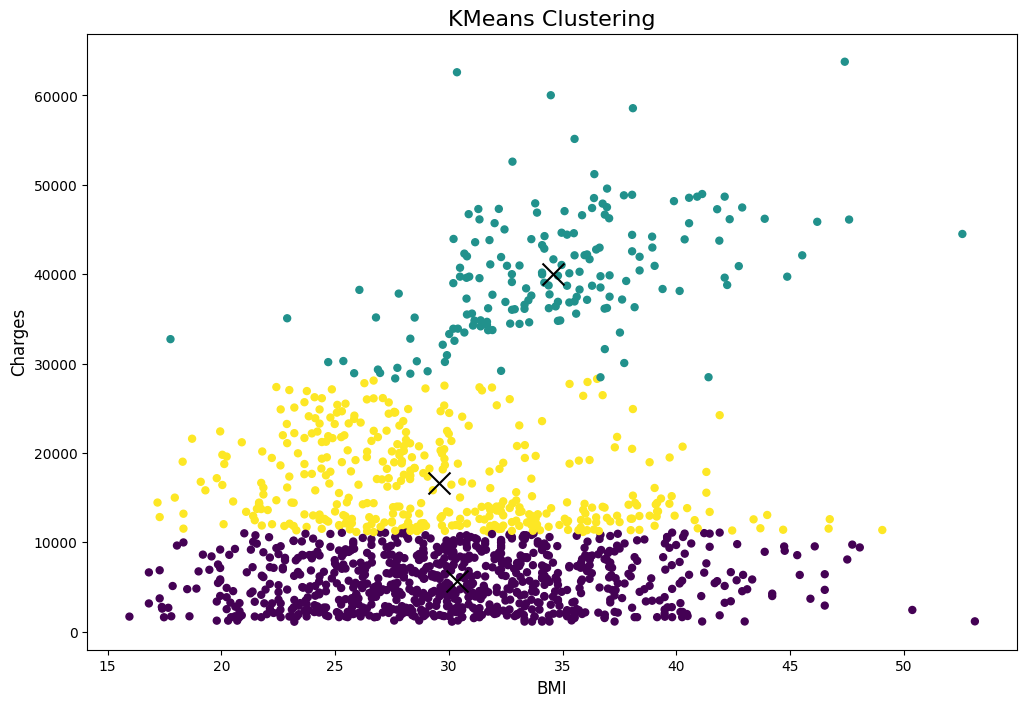

In [20]:
fig = plt.figure(figsize=(12,8))

# Scatter plot of bmi vs charges, color-coded by cluster labels
plt.scatter(X.values[:, 0], X.values[:, 1], c=kmeans.labels_, cmap="viridis", s=25)

# Mark the cluster centers with black 'x' markers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black', marker="x", s=250)

# Add a more specific title and axis labels
plt.title("KMeans Clustering", fontsize=16)
plt.xlabel("BMI", fontsize=12)
plt.ylabel("Charges", fontsize=12)

# Show the plot
plt.show()

In [21]:
from sklearn.metrics import silhouette_score

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(X, kmeans.labels_)

# Print the silhouette score
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.5931598206215869


## Evaluation

In [22]:
df = df_cleaned
not_normalized = skew(df['charges'].values.tolist())
normalized = skew(np.log(df['charges'].values.tolist()))


trace0 = go.Bar(
    x=['Not Normalized', 'Normalized'],
    y=[not_normalized, normalized],
    text=['Not Normalized Skewness', 'Normalized Skewness'],
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5,
        )
    ),
    opacity=0.6
)

data = [trace0]
layout = go.Layout(
    title='Patient Charges Skewness \n Normalized vs Not Normalized',
    yaxis=dict(
        title='Skewness Coeficient',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        )
))

fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='bar-direct-labels')

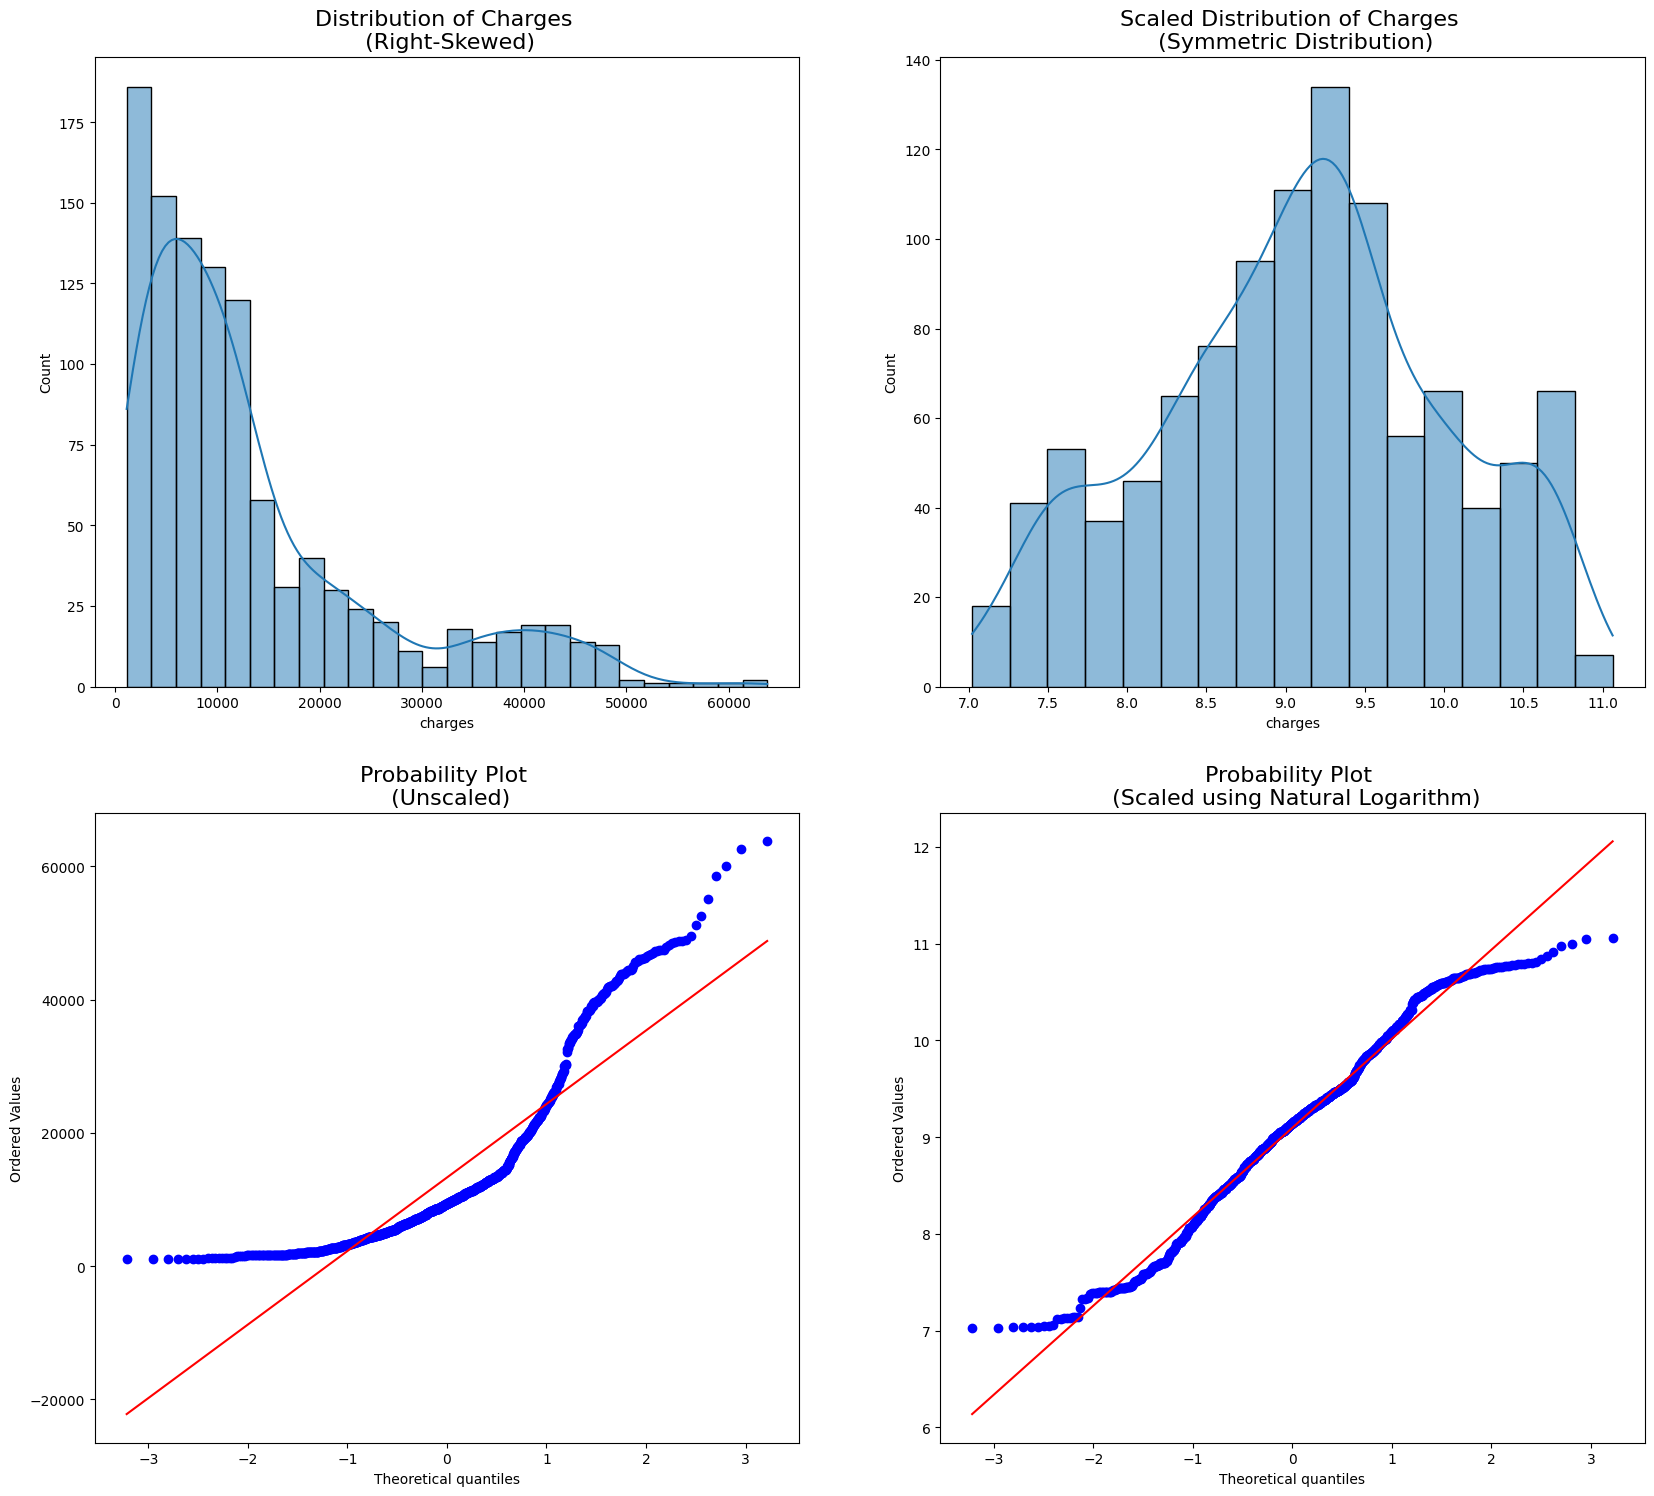

In [23]:
import scipy.stats as stats

# Assuming 'train' is the DataFrame containing your data
charges = df['charges'].values

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,18)) 

# Distribution of charges
sns.histplot(train['charges'], kde=True, ax=ax1)
ax1.set_title("Distribution of Charges \n (Right-Skewed)", fontsize=16)

# Scaling charges using a natural logarithm.
sns.histplot(np.log(train['charges']), kde=True, ax=ax2)
ax2.set_title("Scaled Distribution of Charges \n (Symmetric Distribution)", fontsize=16)

# Quantile plot
stats.probplot(train["charges"], plot=ax3)
ax3.set_title("Probability Plot \n (Unscaled)", fontsize=16)

stats.probplot(np.log(train["charges"]), plot=ax4)
ax4.set_title("Probability Plot \n (Scaled using Natural Logarithm)", fontsize=16)

plt.show()

In [24]:
# Apply the natural log transformation to the target variable (charges)
y_train_log = np.log(y_train)

# Add a constant to the feature set (independent variables)
X_train_log = sm.add_constant(scaled_xtrain)

# Fit the OLS model using the transformed target variable
model_log = sm.OLS(y_train_log, X_train_log)
results_log = model_log.fit()

# Print the summary of the model
print(results_log.summary())

# If you want to make predictions and get them in the original scale of charges
y_pred_log = results_log.predict(X_train_log)  # Predicted log-transformed charges
y_pred = np.exp(y_pred_log)  # Exponentiate to get the predicted charges in original scale

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     240.9
Date:                Sat, 04 Jan 2025   Prob (F-statistic):          2.36e-316
Time:                        21:13:55   Log-Likelihood:                -666.71
No. Observations:                1069   AIC:                             1363.
Df Residuals:                    1054   BIC:                             1438.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5199      0.013    265.285      0.0

In [26]:
import joblib

joblib.dump(model_log, "log_regression_model.pkl")

reg_model = joblib.load("log_regression_model.pkl")

## Deployment

In [29]:
%%writefile app.py

import streamlit as st
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Load the trained model
model = joblib.load("log_regression_model.pkl")  # Update to correct model filename

# Function to preprocess input data
def preprocess_input_data(features):
    # Create a DataFrame from the input features for preprocessing
    df = pd.DataFrame([features], columns=['age', 'bmi', 'children', 'sex', 'smoker', 'region'])
    
    # Preprocess data using the same transformations as during training
    preprocessor = model.named_steps['preprocessor']
    return preprocessor.transform(df)

# Streamlit Interface
st.title('Insurance Charges Prediction')

# Input Fields
age = st.number_input('Age', min_value=18, max_value=100, value=30)
bmi = st.number_input('BMI', min_value=10.0, max_value=50.0, value=25.0)
children = st.number_input('Children', min_value=0, max_value=10, value=2)

sex = st.selectbox('Sex', ['male', 'female'])
smoker = st.selectbox('Smoker', ['yes', 'no'])
region = st.selectbox('Region', ['northwest', 'southeast', 'southwest', 'northeast'])

# Combine inputs into a list (ensure order matches the model's expected input)
features = [age, bmi, children, sex, smoker, region]

# When the user clicks the "Predict" button
if st.button('Predict'):
    # Preprocess the input features
    preprocessed_data = preprocess_input_data(features)
    
    # Make a prediction
    prediction = model.predict(preprocessed_data)
    
    # Display the prediction
    st.write(f'Predicted Insurance Charges: ${prediction[0]:,.2f}')


Writing app.py
